# Import librairies

In [1]:
import pandas as pd
from datetime import date
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Import des datasets

In [ ]:
df_global = pd.read_parquet('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_15min_NoNan_20250505.parquet')

In [ ]:
df_prediction_taux_occupation = pd.read_csv('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/donnees_predictions/taux_occupation_predictions.csv')

In [ ]:
df_prediction_temps_parcours = pd.read_csv('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/donnees_predictions/temps_de_parcours_predictions.csv')

In [ ]:
df_prediction_vitesse = pd.read_csv('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/donnees_predictions/resultats_multivariates_sans_sup_50.csv')

In [ ]:
df_prediction_debit = ('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/donnees_predictions/resultats_debit.csv')

In [ ]:
df_prediction_taux_occupation.columns

Index(['heure_arrondie', 'nom_du_troncon', 'temps_de_parcours_reel',
       'temps_de_parcours_pred'],
      dtype='object')

# Test 1 - RandomForest incluant taux_occupation prédit en cible multiclasse

Prédiction avec un RandomForest sur du multiclasse incluant la variable temporelle précédemment prédite taux_occupation

In [ ]:
# --- Préparation des données ---

df_global['heure_arrondie'] = pd.to_datetime(df_global['heure_arrondie'])
df_prediction_taux_occupation['heure_arrondie'] = pd.to_datetime(df_prediction_taux_occupation['heure_arrondie'])
cutoff_date = pd.to_datetime('2025-03-08')

train_df = df_global[df_global['heure_arrondie'] < cutoff_date].copy()
predict_base_df = df_global[df_global['heure_arrondie'] >= cutoff_date].copy()

# Selection des variables explicatives
feature_cols = ['taux_occupation', 'id', 'weekday', 'hour', 'is_vacances', 'is_ferie', 'has_event_near_troncon']
target_col = 'code_couleur'


# --- Fusion des données ---

# Objectif : retrouver les features correspondant aux prédictions
# On utilise 'nom_du_troncon' et 'heure_arrondie' pour lier la prédiction du LSTM aux données de contexte de df_global
predict_df_merged = pd.merge(
    predict_base_df,
    df_prediction_taux_occupation,
    on=['heure_arrondie', 'nom_du_troncon'], 
    how='inner' 
)

# Remplacer la valeur réelle par la valeur prédite
predict_df_merged['taux_occupation'] = predict_df_merged['taux_occupation_pred']
# Supprimer la colonne de prédiction pour ne pas la retrouver dans les features
predict_df_merged = predict_df_merged.drop(columns=['taux_occupation_pred'])

# --- Encodage uniforme ---
X_train_data = train_df[feature_cols]
# On prend les mêmes colonnes du df fusionné
X_pred_data = predict_df_merged[feature_cols]

# Combinaison pour encodage robuste
X_train_data['source'] = 'train'
X_pred_data['source'] = 'pred'
combined_df = pd.concat([X_train_data, X_pred_data], ignore_index=True)

categorical_cols = ['id', 'hour', 'weekday']
combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_cols, dtype=int)

X_train_final = combined_df_encoded[combined_df_encoded['source'] == 'train'].drop(columns=['source'])
X_to_predict = combined_df_encoded[combined_df_encoded['source'] == 'pred'].drop(columns=['source'])
y_train = train_df[target_col]
X_to_predict = X_to_predict[X_train_final.columns]

# --- Entraînement du modèle ---
print("Entraînement du modèle")
model = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1
)
model.fit(X_train_final, y_train)
print("Modèle entraîné.")

# --- Prédiction ---
predictions = model.predict(X_to_predict)

# Ajouter les prédictions au DataFrame fusionné pour garder une trace
predict_df_merged['code_couleur_predit'] = predictions

# Ajouter la colonne de prédiction à votre DataFrame original en utilisant la même clé de jointure
df_prediction_taux_occupation = pd.merge(
    df_prediction_taux_occupation,
    predict_df_merged[['heure_arrondie', 'nom_du_troncon', 'code_couleur_predit']],
    on=['heure_arrondie', 'nom_du_troncon'],
    how='left'
)

<ipython-input-32-0d88f14db173>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_data['source'] = 'train'
<ipython-input-32-0d88f14db173>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred_data['source'] = 'pred'


Entraînement du modèle
Modèle entraîné.


## Evaluation


--- Rapport de Classification ---
Analyse de la performance pour chaque code couleur :
              precision    recall  f1-score   support

         3.0       1.00      1.00      1.00    492090
         4.0       0.97      0.98      0.98      5396
         5.0       0.97      0.96      0.96      2570
         6.0       0.97      1.00      0.98      3272

    accuracy                           1.00    503328
   macro avg       0.98      0.98      0.98    503328
weighted avg       1.00      1.00      1.00    503328


--- Matrice de Confusion ---
Visualisation des erreurs de classification :


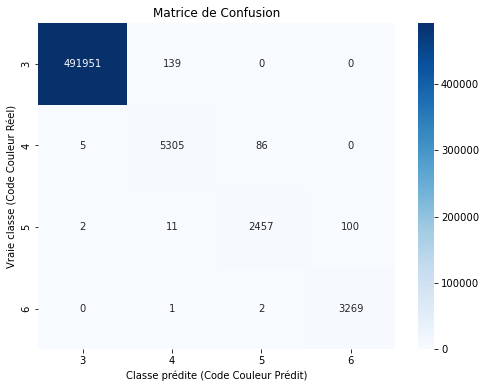

In [ ]:

# ---  Évaluation détaillée de la performance ---

# 1. Définir les vraies valeurs et les valeurs prédites
# Les vraies valeurs pour la période de test
y_true = predict_df_merged['code_couleur']

# Les prédictions que nous venons de faire
y_pred = predictions


# Générer et afficher le Rapport de Classification
print("\n--- Rapport de Classification ---")
print("Analyse de la performance pour chaque code couleur :")
print(classification_report(y_true, y_pred))


# Matrice de confusion
print("\n--- Matrice de Confusion ---")
print("Visualisation des erreurs de classification :")

labels = sorted(y_true.astype(int).unique())

cm = confusion_matrix(y_true, y_pred, labels=labels)

# Affichage 
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe (Code Couleur Réel)')
plt.xlabel('Classe prédite (Code Couleur Prédit)')
plt.show()

## Test 2 - RandomForest incluant taux_occupation prédit en cible binaire

Prédiction avec un RandomForest sur du binaire (Fluide/non-fluide) incluant la variable temporelle précédemment prédite : taux_occupation

<ipython-input-34-b57c2a73591f>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_data['source'] = 'train'
<ipython-input-34-b57c2a73591f>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred_data['source'] = 'pred'


Modèle entraîné.

--- Rapport de Classification Binaire ---
                precision    recall  f1-score   support

    Fluide (0)       1.00      1.00      1.00    492090
Non Fluide (1)       0.99      1.00      0.99     11238

      accuracy                           1.00    503328
     macro avg       0.99      1.00      1.00    503328
  weighted avg       1.00      1.00      1.00    503328


--- Matrice de Confusion Binaire ---


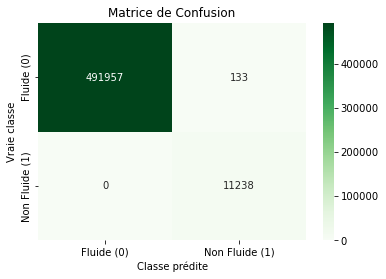

In [ ]:
def map_to_binary(code):
  if code == 3:
    return 0  # Représente 'fluide'
  else:
    return 1  # Représente 'non fluide' (regroupe 4, 5, et 6)

df_global['is_congested'] = df_global['code_couleur'].apply(map_to_binary)

# --- Préparation des données ---
df_global['heure_arrondie'] = pd.to_datetime(df_global['heure_arrondie'])
df_prediction_taux_occupation['heure_arrondie'] = pd.to_datetime(df_prediction_taux_occupation['heure_arrondie'])
cutoff_date = pd.to_datetime('2025-03-08')

train_df = df_global[df_global['heure_arrondie'] < cutoff_date].copy()
predict_base_df = df_global[df_global['heure_arrondie'] >= cutoff_date].copy()

feature_cols = ['taux_occupation', 'id', 'weekday', 'hour', 'is_vacances', 'is_ferie', 'has_event_near_troncon']
target_col = 'is_congested'

# --- Fusion ---
predict_df_merged = pd.merge(
    predict_base_df,
    df_prediction_taux_occupation,
    on=['heure_arrondie', 'nom_du_troncon'],
    how='inner'
)
predict_df_merged['taux_occupation'] = predict_df_merged['taux_occupation_pred']
predict_df_merged = predict_df_merged.drop(columns=['taux_occupation_pred'])


# --- Encodage ---
X_train_data = train_df[feature_cols]
X_pred_data = predict_df_merged[feature_cols]
X_train_data['source'] = 'train'
X_pred_data['source'] = 'pred'
combined_df = pd.concat([X_train_data, X_pred_data], ignore_index=True)
categorical_cols = ['id', 'hour', 'weekday']
combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_cols, dtype=int)
X_train_final = combined_df_encoded[combined_df_encoded['source'] == 'train'].drop(columns=['source'])
X_to_predict = combined_df_encoded[combined_df_encoded['source'] == 'pred'].drop(columns=['source'])
y_train = train_df[target_col] 
X_to_predict = X_to_predict[X_train_final.columns]


# --- Entraînement  ---
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_final, y_train)
print("Modèle entraîné.")


# --- Prédiction  ---

predictions_binary = model.predict(X_to_predict)

# Ajouter la prédiction binaire (0 ou 1)
df_prediction_taux_occupation['is_congested_predit'] = predictions_binary

# Ajouter une colonne avec des labels clairs pour une meilleure lisibilité
df_prediction_taux_occupation['etat_trafic_predit'] = np.where(predictions_binary == 1, 'Non Fluide', 'Fluide')


# --- 7. Évaluation du modèle binaire ---
y_true_binary = predict_df_merged['is_congested']
print("\n--- Rapport de Classification Binaire ---")
target_names = ['Fluide (0)', 'Non Fluide (1)']
print(classification_report(y_true_binary, predictions_binary, target_names=target_names))

print("\n--- Matrice de Confusion Binaire ---")
cm = confusion_matrix(y_true_binary, predictions_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

## Test 3 : Méthode sans machine Learning : application d'un 'seuil' de classification par troncon en fonction tu taux d'occupation median passé. Cible multiclasse

Prédictions multi-classe par seuils terminées.

--- Rapport de Classification (Modèle par Seuils Multi-Classe) ---
              precision    recall  f1-score   support

         3.0       1.00      0.99      0.99    492090
         4.0       0.41      0.99      0.58      5396
         5.0       0.66      0.77      0.71      2570
         6.0       1.00      0.68      0.81      3272

    accuracy                           0.98    503328
   macro avg       0.77      0.86      0.77    503328
weighted avg       0.99      0.98      0.99    503328


--- Matrice de Confusion (Modèle par Seuils Multi-Classe) ---


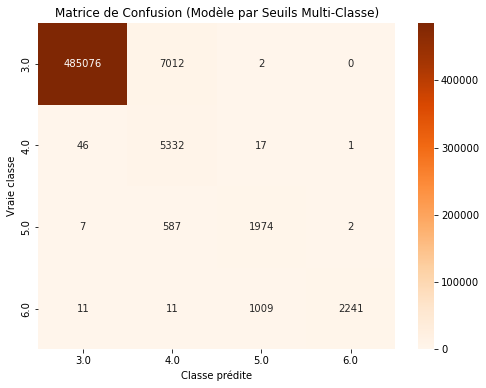

In [ ]:
# --- Préparation des données ---
df_global['heure_arrondie'] = pd.to_datetime(df_global['heure_arrondie'])
df_prediction_taux_occupation = pd.DataFrame({
    'heure_arrondie': df_global[df_global['heure_arrondie'] >= '2025-03-08']['heure_arrondie'],
    'nom_du_troncon': df_global[df_global['heure_arrondie'] >= '2025-03-08']['nom_du_troncon'],
    'taux_occupation_pred': df_global[df_global['heure_arrondie'] >= '2025-03-08']['taux_occupation'] * np.random.uniform(0.9, 1.1)
})
cutoff_date = pd.to_datetime('2025-03-08')
train_df = df_global[df_global['heure_arrondie'] < cutoff_date].copy()
predict_base_df = df_global[df_global['heure_arrondie'] >= cutoff_date].copy()


# --- Calcul des seuils médians par tronçon ET par code couleur ---
seuils_par_troncon = train_df.groupby(['id', 'code_couleur'])['taux_occupation'].median().reset_index()
seuils_par_troncon.rename(columns={'taux_occupation': 'seuil_median_occupation'}, inplace=True)


# --- Prédiction basée sur les seuils multi-classe ---
predict_df_merged = pd.merge(
    predict_base_df,
    df_prediction_taux_occupation,
    on=['heure_arrondie', 'nom_du_troncon'],
    how='inner'
)

def predict_with_thresholds_multiclass(row, seuils_df):
    taux_pred = row['taux_occupation_pred']
    troncon_id = row['id']
    
    seuils_troncon = seuils_df[seuils_df['id'] == troncon_id]
    
    if seuils_troncon.empty:
        return 3 # On prédit 'fluide' par défaut si le tronçon est inconnu
    
    distances = (seuils_troncon['seuil_median_occupation'] - taux_pred).abs()
    closest_idx = distances.idxmin()
    
    return seuils_troncon.loc[closest_idx, 'code_couleur'] # On retourne le 'code_couleur' du seuil le plus proche

predictions = predict_df_merged.apply(predict_with_thresholds_multiclass, axis=1, args=(seuils_par_troncon,))
print("Prédictions multi-classe par seuils terminées.")


# --- Évaluation de la solution ---
y_true = predict_df_merged['code_couleur']
y_pred = predictions

print("\n--- Rapport de Classification (Modèle par Seuils Multi-Classe) ---")
print(classification_report(y_true, y_pred))

print("\n--- Matrice de Confusion (Modèle par Seuils Multi-Classe) ---")
labels = sorted(y_true.unique())
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.title('Matrice de Confusion (Modèle par Seuils Multi-Classe)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

## Test 4 : Méthode sans machine Learning : application d'un 'seuil' de classification par troncon en fonction tu taux d'occupation median passé. Cible binaire : Fluide/non fluide


## Étape 4: Application de la logique de prédiction par seuils ##
Prédictions binaires par seuils terminées.

## Étape 5: Évaluation du modèle de référence binaire ##

--- Rapport de Classification (Modèle par Seuils Binaire) ---
                precision    recall  f1-score   support

    Fluide (0)       1.00      0.98      0.99    492090
Non Fluide (1)       0.57      0.98      0.72     11238

      accuracy                           0.98    503328
     macro avg       0.78      0.98      0.86    503328
  weighted avg       0.99      0.98      0.99    503328


--- Matrice de Confusion (Modèle par Seuils Binaire) ---


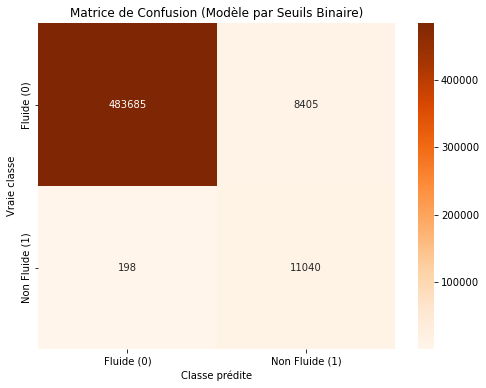

In [ ]:
# --- Transformation du problème en binaire ---
df_global['is_congested'] = df_global['code_couleur'].apply(lambda code: 0 if code == 3 else 1)


# --- Préparation des données ---
df_global['heure_arrondie'] = pd.to_datetime(df_global['heure_arrondie'])
df_prediction_taux_occupation = pd.DataFrame({
    'heure_arrondie': df_global[df_global['heure_arrondie'] >= '2025-03-08']['heure_arrondie'],
    'nom_du_troncon': df_global[df_global['heure_arrondie'] >= '2025-03-08']['nom_du_troncon'],
    'taux_occupation_pred': df_global[df_global['heure_arrondie'] >= '2025-03-08']['taux_occupation'] * np.random.uniform(0.9, 1.1)
})
cutoff_date = pd.to_datetime('2025-03-08')
train_df = df_global[df_global['heure_arrondie'] < cutoff_date].copy()
predict_base_df = df_global[df_global['heure_arrondie'] >= cutoff_date].copy()


# --- Calcul des seuils médians par tronçon ET par CLASSE BINAIRE ---
seuils_par_troncon = train_df.groupby(['id', 'is_congested'])['taux_occupation'].median().reset_index()
seuils_par_troncon.rename(columns={'taux_occupation': 'seuil_median_occupation'}, inplace=True)


# --- Logique de prédiction basée sur les seuils binaires ---
predict_df_merged = pd.merge(
    predict_base_df,
    df_prediction_taux_occupation,
    on=['heure_arrondie', 'nom_du_troncon'],
    how='inner'
)

def predict_with_thresholds_binary(row, seuils_df):
    taux_pred = row['taux_occupation_pred']
    troncon_id = row['id']
    
    seuils_troncon = seuils_df[seuils_df['id'] == troncon_id]
    
    if seuils_troncon.empty:
        return 0 # On prédit 'fluide' par défaut si le tronçon est inconnu
    
    distances = (seuils_troncon['seuil_median_occupation'] - taux_pred).abs()
    closest_idx = distances.idxmin()
  
    return seuils_troncon.loc[closest_idx, 'is_congested'] # On retourne la classe binaire 'is_congested' du seuil le plus proche

predictions = predict_df_merged.apply(predict_with_thresholds_binary, axis=1, args=(seuils_par_troncon,))
predictions.fillna(0, inplace=True) # Remplir les quelques cas non prédits
print("Prédictions binaires par seuils terminées.")


# --- Évaluation du modèle de référence binaire ---
y_true = predict_df_merged['is_congested']
y_pred = predictions

print("\n--- Rapport de Classification (Modèle par Seuils Binaire) ---")
target_names = ['Fluide (0)', 'Non Fluide (1)']
print(classification_report(y_true, y_pred, target_names=target_names))

print("\n--- Matrice de Confusion (Modèle par Seuils Binaire) ---")
labels = sorted(y_true.unique())
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion (Modèle par Seuils Binaire)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()